In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# --- 1. Define the path to your saved model ---
model_path = "./sentiment_analysis_model"
print(f"Loading model from {model_path}...")

# --- 2. Load the fine-tuned model and tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# --- 3. Load and prepare the SAME validation data ---
print("Loading and preparing data...")
df = pd.read_csv('./dev/data/sentiment_data.csv', encoding='latin1')
df.dropna(inplace=True)

# Recreate the same label mappings from your training script
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
df['label'] = df['Sentiment'].map(label_map)

# Split the data with the same random_state to get the same validation set
_, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

Loading model from ./fine_tuned_categorizer...
Loading and preparing data...


In [15]:
val_encodings = tokenizer(val_df['Sentence'].tolist(), truncation=True, padding=True)

class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

val_dataset = FinancialDataset(val_encodings, val_df['label'].tolist())

In [16]:
print("Running predictions on the validation set...")

# We still use a Trainer, but only to run the prediction
trainer = Trainer(model=model)
predictions_output = trainer.predict(val_dataset)

# The actual predictions are the argmax of the logits
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

Running predictions on the validation set...


c:\anaconda3\envs\finance_env\Lib\site-packages\torch\nn\modules\module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Generating confusion matrix...


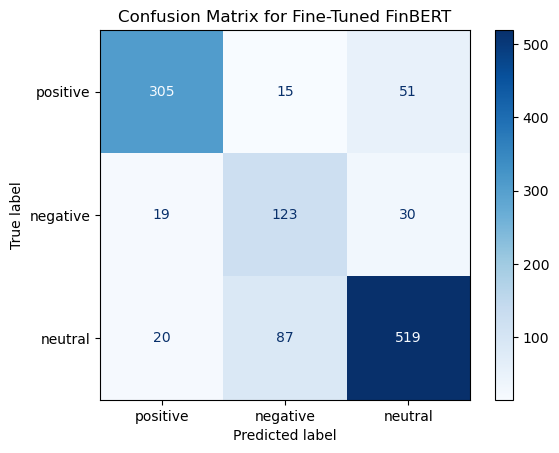

In [17]:
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.id2label.values())

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fine-Tuned FinBERT")
plt.show()

In [18]:
print(classification_report(y_true, y_pred, target_names=['positive', 'negative', 'neutral']))

              precision    recall  f1-score   support

    positive       0.89      0.82      0.85       371
    negative       0.55      0.72      0.62       172
     neutral       0.86      0.83      0.85       626

    accuracy                           0.81      1169
   macro avg       0.77      0.79      0.77      1169
weighted avg       0.83      0.81      0.82      1169

